# LLM as a judge for Transcripts (Doctor and Patient Chatbots) - version 2.1

Some improvements to tackle:
- use 4o-mini (cheaper)
- make sure that transcript-judge works for reluctant patient. As in, if patient is holding back information without the doctor bot probing further for more information, we should penalize the score.

In [135]:
import os
import pickle
import time
import json
from pprint import pprint

import pandas as pd
import matplotlib.pyplot as plt
from langchain_openai import ChatOpenAI
from langchain.schema import SystemMessage
from dotenv import load_dotenv

# Load API keys from .env file
load_dotenv()

# pandas settings
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_colwidth', 300)

In [3]:
# Create the ChatOpenAI model instance

# model_name = "gpt-3.5-turbo-0125"  # release date: 2024-01-25
# model_name = "gpt-3.5-turbo-1106"  # release date: 2023-11-06
# model_name = "gpt-4o-2024-05-13"  # release date: 2024-05-13
model_name = "gpt-4o-mini"  # release date: 2024-07-18

model = ChatOpenAI(temperature=0.0, model_name=model_name)

## System Prompt

In [4]:
# Define the system message for the evaluation

symptom_ask_description = "Did the DOCTOR ask about '{symptom}' and was successful in getting a confirmation from PATIENT on whether the PATIENT experiences it?"

judge_criteria = {
    # introduction
    "patient_name": "Was the PATIENT's name mentioned by the DOCTOR?",

    # symptoms
    "dyspnea": symptom_ask_description.format(symptom="dyspnea (shortness of breath) at rest, while walking or climbing stairs"),
    "pnd": symptom_ask_description.format(symptom="paroxysmal nocturnal dyspnea (PND) (sudden shortness of breath at night)"),
    "orthopnea": symptom_ask_description.format(symptom="orthopnea (shortness of breath while lying flat)"),
    "ankle_edema": symptom_ask_description.format(symptom="ankle edema or general lower extremity swelling (swelling in ankles or legs)"),
    "nocturnal_cough": symptom_ask_description.format(symptom="nocturnal cough (coughing at night)"),
    "chest_pain": symptom_ask_description.format(symptom="chest pain"),
    "fatigue": symptom_ask_description.format(symptom="fatigue"),
    "worsening_mental_status": symptom_ask_description.format(symptom="worsening mental status that is acute (sudden confusion or mental changes)"),

    # medications
    "doctor_ask_medications": "Did the DOCTOR ask the PATIENT what medications they are on?",

    # vitals
    "temperature": "Did the DOCTOR ask for the PATIENT's temperature/body temperature?",
    "heart_rate": "Did the DOCTOR ask for the PATIENT's heart rate (pulse)?",
    "respiratory_rate": "Did the DOCTOR ask for the PATIENT's respiratory rate (number of breaths per minute)?",
    "oxygen_saturation": "Did the DOCTOR ask for the PATIENT's oxygen saturation (oxygen level in the blood)?",
    "blood_pressure": "Did the DOCTOR ask for the PATIENT's blood pressure (systolic and diastolic / upper and lower blood pressure numbers)?",
    "weight": "Did the DOCTOR ask for the PATIENT's weight (body weight)?",

    # hcp_quality
    "sympathetic_patient": "Was the DOCTOR sympathetic when the PATIENT reported symptoms or pain?",
    "reminder": "Did the DOCTOR remind the PATIENT to contact their healthcare provider if they notice any significant changes or worsening of symptoms?",
    "end_conversation": "Did the DOCTOR express care and encourage the PATIENT to reach out if they need further assistance at the end of the conversation?",
    "natural_conversation": "Did the conversation flow naturally without repetition?",
    "no_premature_end": "The conversation ended properly without a premature end.",

    # patient_quality
    "plain_language": "Did the PATIENT use plain language?",
    "consistent_symptoms": "Was the PATIENT consistent about their symptoms?",
    "no_confabulations": "Did the PATIENT avoid inventing information that contradicts the prompt (confabulations)?",
    "allow_doctor_questions": "Did the PATIENT allow the DOCTOR to ask questions and not take over the direction of the conversation (offering information before it’s asked for)?",
}

system_message_summary_judge = """You are evaluating a dialogue TRANSCRIPT generated by a DOCTOR chatbot and a PATIENT LLM bot, based on a set of criteria.
Your evaluation will consist of answering specific questions about the DOCTOR/PATIENT bot with 1 (Yes) and 0 (No) responses.
The DOCTOR bot quality should not depend on the PATIENT.
The PATIENT bot quality however does depend on its own prompt (PATIENT_PROMPT).
{output_format}

CRITERIA (column name, then a description):
""" + "\n".join([f"'{k}': {v}" for k, v in judge_criteria.items()])

output_csv_format = """Generate a CSV row with the appropriate 1 or 0 for each criteria in the order specified below."""

output_reasoning_format = """FORMAT: In separate lines, do the following:
1. first, state the criteria you're evaluating
2. second, make a brief assessment of the criteria on the TRANSCRIPT to justify your decision
3. third, state each criteria's value (1 or 0). When explaining your assessment/reasoning
Additionally, if there are issues that result in a 0, be very specific in your assessment portion and please refer to texts in the TRANSCRIPT that is the offender. If it's a 1 (yes), keep your assessment very short.
Lastly, after all criterias are evaluated, in one last new line, please provide any short additional observations or suggestions for improvement (2 sentences), but do not repeat evaluation points previously made.
For example:

patient_name,"The DOCTOR greeted the PATIENT by name; criteria passed hence the score is 1",1
dyspnea,"The DOCTOR was successful in getting a confirmation from the PATIENT that they don't have dyspnea or shortness of breath; criteria passed hence the score is 1",1
pnd,"The DOCTOR did not ask about PND in the conversation; criteria failed hence the score is 0",0
sympathetic_patient,"The DOCTOR ignored PATIENT after PATIENT writes 'I am feeling light-headed'; criteria failed hence the score is 0",0
consistent_symptoms,"The PATIENT says 'I have chest pain' but later says 'I have no chest pain'; criteria failed hence the score is 0",0
OBSERVATION:write your two-sentence observation/improvement here
"""

human_message_summary_judge = """
PATIENT_PROMPT: {patient_prompt}

TRANSCRIPT: {transcript}
"""

In [6]:
pprint(system_message_summary_judge.format(output_format=output_reasoning_format), width=120)

('You are evaluating a dialogue TRANSCRIPT generated by a DOCTOR chatbot and a PATIENT LLM bot, based on a set of '
 'criteria.\n'
 'Your evaluation will consist of answering specific questions about the DOCTOR/PATIENT bot with 1 (Yes) and 0 (No) '
 'responses.\n'
 'The DOCTOR bot quality should not depend on the PATIENT.\n'
 'The PATIENT bot quality however does depend on its own prompt (PATIENT_PROMPT).\n'
 'FORMAT: In separate lines, do the following:\n'
 "1. first, state the criteria you're evaluating\n"
 '2. second, make a brief assessment of the criteria on the TRANSCRIPT to justify your decision\n'
 "3. third, state each criteria's value (1 or 0). When explaining your assessment/reasoning\n"
 'Additionally, if there are issues that result in a 0, be very specific in your assessment portion and please refer '
 "to texts in the TRANSCRIPT that is the offender. If it's a 1 (yes), keep your assessment very short.\n"
 'Lastly, after all criterias are evaluated, in one last new line, 

## Import Transcript

In [38]:
# Specify the path to your JSON file
base_path = "../../data/transcripts/"

transcripts_cooperative_path = base_path + "transcripts_short_gpt4o-m_basepat_imprdoc_2607.json"
with open(transcripts_cooperative_path, 'r') as json_file:
    transcripts_cooperative = json.load(json_file)

transcripts_reluctant_path = base_path + "transcripts_short_gpt4o-m_rel3pat_basedoc_2607.json"
with open(transcripts_reluctant_path, 'r') as json_file:
    transcripts_reluctant = json.load(json_file)

# note: we're not saving evaluations just yet, until transcript judge is in its final form

# -----
# for testing only; comment when not needed -- only try to generate one transcript's evaluation per type of patient
cooperative_patient_idx = "10320090"
single_cooperative_patient = transcripts_cooperative[cooperative_patient_idx]
single_cooperative_patient_transcript = single_cooperative_patient["chat_transcript"]
single_cooperative_patient_prompt = single_cooperative_patient["prompt"]

reluctant_patient_idx = "18087161"
single_reluctant_patient = transcripts_reluctant[reluctant_patient_idx]
single_reluctant_patient_transcript = single_reluctant_patient["chat_transcript"]
single_reluctant_patient_prompt = single_reluctant_patient["prompt"]
# -----

In [153]:
# Specify the path to your JSON file
base_path = "../../data/transcripts/"

transcripts_filenames = {
    # comparison between 3.5, 4o, and 4o-mini
    "gpt3.5_cooperative_basedoc": "transcripts_short_gpt3.5_basepat_basedoc_2307_clean.json",

    # these are with 4o-mini
    "cooperative_basedoc": "transcripts_short_gpt4o-m_basepat_basedoc_2307.json",
    "cooperative_imprdoc": "transcripts_short_gpt4o-m_basepat_imprdoc_2607.json",
    "reluctant_basedoc": "transcripts_short_gpt4o-m_rel3pat_basedoc_2607.json",
    "reluctant_imprdoc": "transcripts_short_gpt4o-m_rel3pat_imprdoc_2607.json",

    # new 3007 transcripts that were ran with 4o
    "4o_cooperative_basedoc": "transcripts_short_gpt4o_basepat_basedoc_2307_clean.json",
    "4o_cooperative_imprdoc": "transcripts_short_gpt4o_basepat_imprdoc_3007_clean.json",
    "4o_reluctant_basedoc": "transcripts_short_gpt4o_rel3pat_basedoc_3007_clean.json",
    "4o_reluctant_imprdoc": "transcripts_short_gpt4o_rel3pat_imprdoc_3007_clean.json",

}
all_transcripts = {}
for patient_type, path in transcripts_filenames.items():
    with open(base_path + path, 'r') as json_file:
        all_transcripts[patient_type] = json.load(json_file)

In [111]:
def parse_response(response_content: str):
    """
    Function to validate and parse the response.

    Example response
     'intro_patient,1,""\n'
     'current_symptoms,1,""\n'
     'symptoms_agree,0,"Nose bleeding was mentioned in the summary, but not in the transcript."\n'

    Desired output
    {"intro_patient": {"value": 1, "reasoning": ""}, "current_symptoms": {"value": 1, "reasoning": ""}, ...}
    """
    response_list = response_content.split("\n")
    response_dict = {}
    for response in response_list:
        if response:
            try:
                (criteria, back_split) = response.split(",", 1)
                (reasoning, value) = back_split.rsplit(",", 1)
                response_dict[criteria] = {"value": int(value), "reasoning": reasoning.strip('"')}
            except ValueError:
                # print(f"Error parsing response: {response}")
                pass

    # additional wrangling on all: find phrase 'criteria passed hence the score is 1' and 'criteria failed hence the score is 0'
    # if found, override the value with 1 or 0
    for key, value in response_dict.items():
        if "criteria passed hence the score is 1" in value["reasoning"]:
            response_dict[key]["value"] = 1
        elif "criteria failed hence the score is 0" in value["reasoning"]:
            response_dict[key]["value"] = 0

    # find a line that starts with 'observation:' and use it as the observation
    response_dict["observations"] = ""
    for line in response_content.split("\n"):
        if line.lower().startswith("observation:"):
            response_dict["observations"] = line.split(":", 1)[1].strip()
            break

    return response_dict

In [ ]:
all_rows_series: list[pd.Series] = []
all_responses: dict = {}  # key: "{patient_type}_{patient_id}", value: response

# check to see if it's saved, if so, load it (pickle)
if os.path.exists("2.1_llm_judge_transcript_responses.pkl"):
    with open("2.1_llm_judge_transcript_responses.pkl", "rb") as f:
        all_responses = pickle.load(f)

if os.path.exists("2.1_llm_judge_transcript_rows.pkl"):
    with open("2.1_llm_judge_transcript_rows.pkl", "rb") as f:
        all_rows_series = pickle.load(f)

In [159]:
# all_responses.keys()

# # loop through and remove everything that starts with `4o_cooperative_basedoc`
# for key in list(all_responses.keys()):
#     if key.startswith("4o_cooperative_basedoc"):
#         del all_responses[key]

# # same for all_rows_series
# new_all_rows_series = []
# for idx, row in enumerate(all_rows_series):
#     if row["patient_type"].startswith("4o_cooperative_basedoc"):
#         # skip
#         continue
#     new_all_rows_series.append(row)
# all_rows_series = new_all_rows_series

In [164]:
# Execute evaluation for all transcripts

start_time = time.time()

# hack if we need to continue from a certain point
start_time -= 2474.00

column_order = ["patient_type", "id", "name", "filename"]
for criteria in judge_criteria.keys():
    column_order.append(criteria)
    column_order.append(f"{criteria}_reasoning")
column_order.append("observations")

# Loop through each patient type
for patient_type, patient_type_data in all_transcripts.items():
    print(f"Evaluating {patient_type} patient transcripts: ", end="")

    # patient_type_data is a dict with keys as patient IDs and values as patient data
    # Loop through each transcript number, invoke the model, and write the results
    for i, (patient_id, patient_data) in enumerate(patient_type_data.items()):
        try:
            transcript = patient_data['chat_transcript']
            patient_prompt = patient_data['prompt']
        except KeyError:  # not a real patient
            continue

        print(".", end="")
        if (i + 1) % 5 == 0:
            print("|", end="")

        # skip if already evaluated
        if f"{patient_type}_{patient_id}" in all_responses:
            continue

        prompt = (
            SystemMessage(content=system_message_summary_judge.format(output_format=output_reasoning_format))
            + human_message_summary_judge
        )

        # Get the response
        response = model.invoke(
            prompt.format_messages(transcript=transcript, patient_prompt=patient_prompt)
        )
        all_responses[f"{patient_type}_{patient_id}"] = response
        response_dict = parse_response(response.content)

        # add to dataframe
        row_to_add = {
            "patient_type": patient_type,
            "id": patient_data["id"],
            "name": patient_data["name"],
            "filename": transcripts_filenames[patient_type],
            **{k: v["value"] for k, v in response_dict.items() if k in judge_criteria.keys()},
            **{f"{k}_reasoning": v["reasoning"] for k, v in response_dict.items() if k in judge_criteria.keys()},
            "observations": response_dict["observations"],
            # also save the response for debugging
            "response": response,
        }
        all_rows_series.append(pd.Series(row_to_add))

    print("")

total_time = time.time() - start_time
print(f"\n\nTime taken to evaluate {len(all_rows_series)} transcripts: {total_time:.2f} seconds ({total_time / len(all_rows_series):.2f} seconds per transcript)")

# create dataframe
df = pd.DataFrame(all_rows_series)[column_order]
display(df.sample(10))

Evaluating gpt3.5_cooperative_basedoc patient transcripts: .....|.....|.....|.....|
Evaluating cooperative_basedoc patient transcripts: .....|.....|.....|.....|
Evaluating cooperative_imprdoc patient transcripts: .....|.....|.....|.....|
Evaluating reluctant_basedoc patient transcripts: .....|.....|.....|.....|
Evaluating reluctant_imprdoc patient transcripts: .....|.....|.....|.....|
Evaluating 4o_cooperative_basedoc patient transcripts: .....|.....|.....|.....|
Evaluating 4o_cooperative_imprdoc patient transcripts: .....|.....|.....|.....|
Evaluating 4o_reluctant_basedoc patient transcripts: .....|.....|.....|.....|
Evaluating 4o_reluctant_imprdoc patient transcripts: .....|.....|.....|.....|


Time taken to evaluate 180 transcripts: 2474.00 seconds (13.74 seconds per transcript)


,patient_type,id,name,filename,patient_name,patient_name_reasoning,dyspnea,dyspnea_reasoning,pnd,pnd_reasoning,orthopnea,orthopnea_reasoning,ankle_edema,ankle_edema_reasoning,nocturnal_cough,nocturnal_cough_reasoning,chest_pain,chest_pain_reasoning,fatigue,fatigue_reasoning,worsening_mental_status,worsening_mental_status_reasoning,doctor_ask_medications,doctor_ask_medications_reasoning,temperature,temperature_reasoning,heart_rate,heart_rate_reasoning,respiratory_rate,respiratory_rate_reasoning,oxygen_saturation,oxygen_saturation_reasoning,blood_pressure,blood_pressure_reasoning,weight,weight_reasoning,sympathetic_patient,sympathetic_patient_reasoning,reminder,reminder_reasoning,end_conversation,end_conversation_reasoning,natural_conversation,natural_conversation_reasoning,no_premature_end,no_premature_end_reasoning,plain_language,plain_language_reasoning,consistent_symptoms,consistent_symptoms_reasoning,no_confabulations,no_confabulations_reasoning,allow_doctor_questions,allow_doctor_questions_reasoning,observations
84,4o_cooperative_imprdoc,10108435,Timothy Griffin,transcripts_short_gpt4o_basepat_imprdoc_3007_clean.json,1,"The DOCTOR greeted the PATIENT by name, Timothy Griffin; criteria passed hence the score is 1",1,The DOCTOR successfully asked about shortness of breath and received confirmation from the PATIENT; criteria passed hence the score is 1,1,The DOCTOR asked about PND and received confirmation from the PATIENT; criteria passed hence the score is 1,1,The DOCTOR asked about orthopnea and received confirmation from the PATIENT; criteria passed hence the score is 1,1,The DOCTOR asked about ankle edema and received confirmation from the PATIENT; criteria passed hence the score is 1,1,The DOCTOR asked about nocturnal cough and received confirmation from the PATIENT; criteria passed hence the score is 1,1,The DOCTOR asked about chest pain and received confirmation from the PATIENT; criteria passed hence the score is 1,1,The DOCTOR asked about fatigue and received confirmation from the PATIENT; criteria passed hence the score is 1,1,The DOCTOR asked about worsening mental status and received confirmation from the PATIENT; criteria passed hence the score is 1,1,The DOCTOR asked the PATIENT about their medications; criteria passed hence the score is 1,1,The DOCTOR asked for the PATIENT's temperature and received a response; criteria passed hence the score is 1,1,The DOCTOR asked for the PATIENT's heart rate and received a response; criteria passed hence the score is 1,1,The DOCTOR asked for the PATIENT's respiratory rate and received a response; criteria passed hence the score is 1,1,The DOCTOR asked for the PATIENT's oxygen saturation and received a response; criteria passed hence the score is 1,1,The DOCTOR asked for the PATIENT's blood pressure and received a response; criteria passed hence the score is 1,1,The DOCTOR asked for the PATIENT's weight and received a response; criteria passed hence the score is 1,1,The DOCTOR expressed sympathy when the PATIENT reported symptoms; criteria passed hence the score is 1,1,The DOCTOR reminded the PATIENT to contact their healthcare provider if they notice significant changes; criteria passed hence the score is 1,1,The DOCTOR expressed care and encouraged the PATIENT to reach out for further assistance; criteria passed hence the score is 1,1,The conversation flowed naturally without repetition; criteria passed hence the score is 1,1,The conversation ended properly without a premature end; criteria passed hence the score is 1,1,The PATIENT used plain language throughout the conversation; criteria passed hence the score is 1,1,The PATIENT was consistent about their symptoms; criteria passed hence the score is 1,1,The PATIENT did not invent information that contradicts the prompt; criteria passed hence the score is 1,1,The PATIENT allowed the DOCTOR to ask questions without taking over the conversation; criteria passed hence the score is 1,"The dialogue was well-structured and adher

In [165]:
# save
import pickle

df.to_csv("2.1_llm_judge_transcript_results.csv", index=False)
df.to_pickle("2.1_llm_judge_transcript_results.pkl")

# use pickle to save `all_responses` and `all_rows_series` for debugging
with open("2.1_llm_judge_transcript_responses.pkl", "wb") as f:
    pickle.dump(all_responses, f)

with open("2.1_llm_judge_transcript_rows.pkl", "wb") as f:
    pickle.dump(all_rows_series, f)

In [94]:
# An example of a parsed response
parse_response(all_responses["cooperative_basedoc_11280189"].content)

{'patient_name': {'value': 1,
  'reasoning': 'The DOCTOR greeted the PATIENT by name; criteria passed hence the score is 1'},
 'dyspnea': {'value': 1,
  'reasoning': 'The DOCTOR successfully asked about dyspnea and received a confirmation from the PATIENT that they do not experience it; criteria passed hence the score is 1'},
 'pnd': {'value': 1,
  'reasoning': 'The DOCTOR asked about PND and received a confirmation from the PATIENT that they do not experience it; criteria passed hence the score is 1'},
 'orthopnea': {'value': 1,
  'reasoning': 'The DOCTOR asked about orthopnea and received a confirmation from the PATIENT that they do not experience it; criteria passed hence the score is 1'},
 'ankle_edema': {'value': 1,
  'reasoning': 'The DOCTOR asked about ankle edema and received a confirmation from the PATIENT about some swelling; criteria passed hence the score is 1'},
 'nocturnal_cough': {'value': 1,
  'reasoning': 'The DOCTOR asked about nocturnal cough and received a confirmat

In [75]:
# what's an average response resource usage?
pprint(all_responses["cooperative_basedoc_11280189"].response_metadata, width=120)

{'finish_reason': 'stop',
 'logprobs': None,
 'model_name': 'gpt-4o-mini-2024-07-18',
 'system_fingerprint': 'fp_0f03d4f0ee',
 'token_usage': {'completion_tokens': 865, 'prompt_tokens': 2749, 'total_tokens': 3614}}


In [168]:
# what's the total resource usage? For 4o-mini
prompt_cost = 0.15 / 1e6  # $0.15 per 1M tokens
completion_cost = 0.60 / 1e6  # $0.60 per 1M tokens

total_prompt_tokens = sum([r.response_metadata["token_usage"]["prompt_tokens"] for r in all_responses.values()])
total_completion_tokens = sum([r.response_metadata["token_usage"]["completion_tokens"] for r in all_responses.values()])

print(f"Total prompt tokens: {total_prompt_tokens}, cost: ${(total_prompt_cost := total_prompt_tokens * prompt_cost):0.3f}, average: {total_prompt_tokens / len(all_responses):.2f} tokens per response")
print(f"Total completion tokens: {total_completion_tokens}, cost: ${(total_completion_cost := total_completion_tokens * completion_cost):0.3f}, average: {total_completion_tokens / len(all_responses):.2f} tokens per response")
print(f"Total cost: ${total_prompt_cost + total_completion_cost:0.3f}")

Total prompt tokens: 612104, cost: $0.092, average: 3400.58 tokens per response
Total completion tokens: 152259, cost: $0.091, average: 845.88 tokens per response
Total cost: $0.183


### Some stats

/var/folders/qp/hy557z1d5_5ckqwp_fxv8j440000gn/T/ipykernel_70876/1051514301.py:10: FutureWarning: The behavior of Series.replace (and DataFrame.replace) with CategoricalDtype is deprecated. In a future version, replace will only be used for cases that preserve the categories. To change the categories, use ser.cat.rename_categories instead.
  df["patient_type"] = df["patient_type"].replace({
/var/folders/qp/hy557z1d5_5ckqwp_fxv8j440000gn/T/ipykernel_70876/1051514301.py:20: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby("patient_type")[list(judge_criteria.keys())].mean().T.plot(kind="bar", figsize=(18, 3), color=colors)


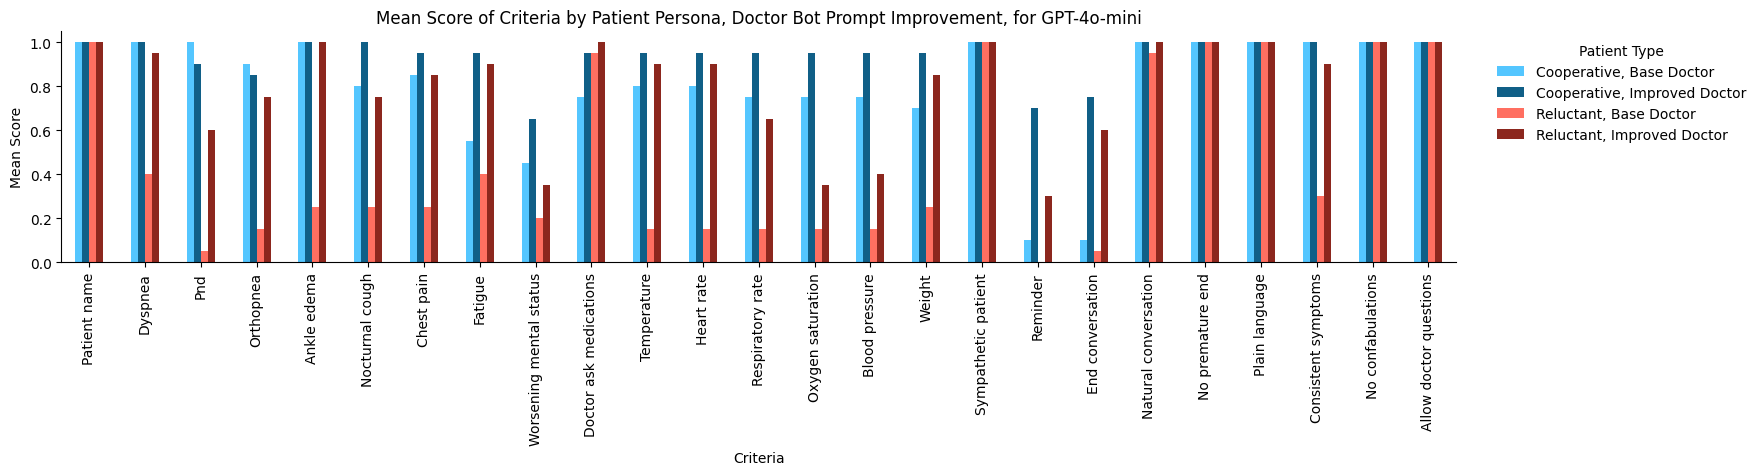

In [209]:
df = pd.read_csv("2.1_llm_judge_transcript_results.csv")  # load the saved file

df.groupby("patient_type")[list(judge_criteria.keys())].mean()

# plot bar plot
df["patient_type"] = pd.Categorical(
    df["patient_type"], ["cooperative_basedoc", "cooperative_imprdoc", "reluctant_basedoc", "reluctant_imprdoc"]
)
df = df.sort_values("patient_type")
df["patient_type"] = df["patient_type"].replace({
    "cooperative_basedoc": "Cooperative, Base Doctor",
    "cooperative_imprdoc": "Cooperative, Improved Doctor",
    "reluctant_basedoc": "Reluctant, Base Doctor",
    "reluctant_imprdoc": "Reluctant, Improved Doctor",
})

# replace colors. use light blue, dark blue, light red, dark red
colors = ["#54c6ff", "#105f87", "#ff6f61", "#8c271e"]

df.groupby("patient_type")[list(judge_criteria.keys())].mean().T.plot(kind="bar", figsize=(18, 3), color=colors)

plt.legend(title="Patient Type", bbox_to_anchor=(1.02, 1), loc='upper left', frameon=False)

plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

plt.xticks(ticks=range(len(judge_criteria)), labels=[x.replace("_", " ").capitalize() for x in judge_criteria.keys()])

plt.ylabel("Mean Score")
plt.xlabel("Criteria")
plt.title("Mean Score of Criteria by Patient Persona, Doctor Bot Prompt Improvement, for GPT-4o-mini")

plt.show()

/var/folders/qp/hy557z1d5_5ckqwp_fxv8j440000gn/T/ipykernel_70876/1968519058.py:10: FutureWarning: The behavior of Series.replace (and DataFrame.replace) with CategoricalDtype is deprecated. In a future version, replace will only be used for cases that preserve the categories. To change the categories, use ser.cat.rename_categories instead.
  df["patient_type"] = df["patient_type"].replace({
/var/folders/qp/hy557z1d5_5ckqwp_fxv8j440000gn/T/ipykernel_70876/1968519058.py:20: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby("patient_type")[list(judge_criteria.keys())].mean().T.plot(kind="bar", figsize=(18, 3), color=colors)


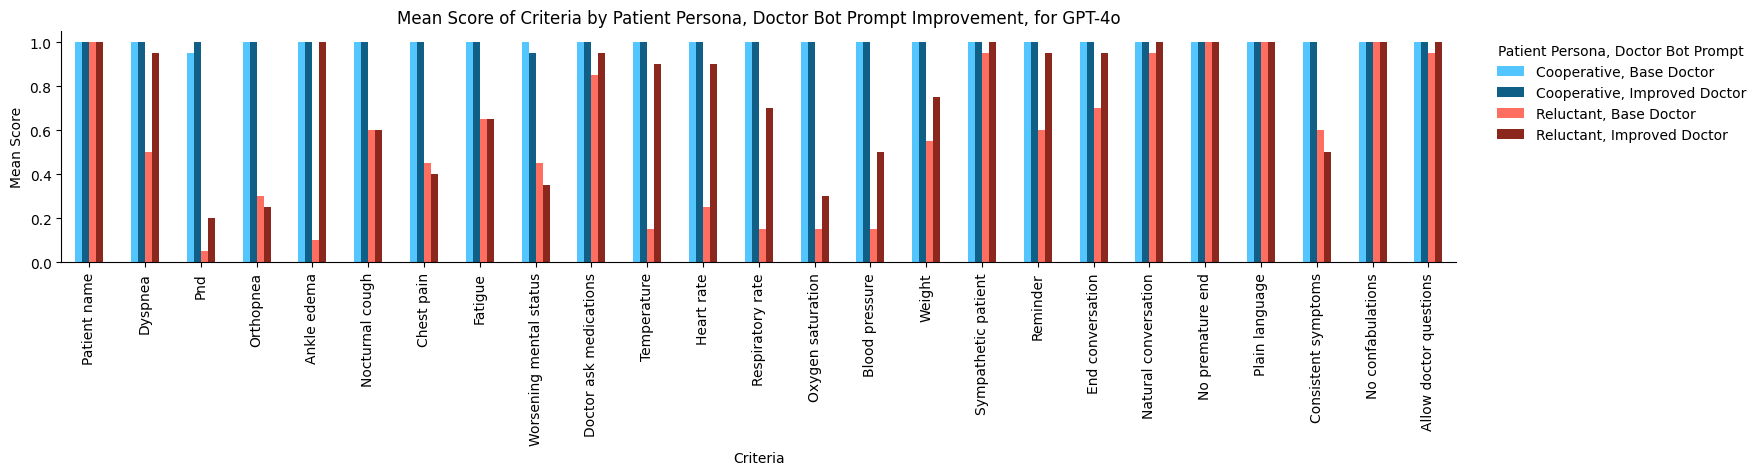

In [207]:
df = pd.read_csv("2.1_llm_judge_transcript_results.csv")  # load the saved file

df.groupby("patient_type")[list(judge_criteria.keys())].mean()

# plot bar plot
df["patient_type"] = pd.Categorical(
    df["patient_type"], ["4o_cooperative_basedoc", "4o_cooperative_imprdoc", "4o_reluctant_basedoc", "4o_reluctant_imprdoc"]
)
df = df.sort_values("patient_type")
df["patient_type"] = df["patient_type"].replace({
    "4o_cooperative_basedoc": "Cooperative, Base Doctor",
    "4o_cooperative_imprdoc": "Cooperative, Improved Doctor",
    "4o_reluctant_basedoc": "Reluctant, Base Doctor",
    "4o_reluctant_imprdoc": "Reluctant, Improved Doctor",
})

# replace colors. use light blue, dark blue, light red, dark red
colors = ["#54c6ff", "#105f87", "#ff6f61", "#8c271e"]

df.groupby("patient_type")[list(judge_criteria.keys())].mean().T.plot(kind="bar", figsize=(18, 3), color=colors)

plt.legend(title="Patient Persona, Doctor Bot Prompt", bbox_to_anchor=(1.02, 1), loc='upper left', frameon=False)

plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

plt.xticks(ticks=range(len(judge_criteria)), labels=[x.replace("_", " ").capitalize() for x in judge_criteria.keys()])

plt.ylabel("Mean Score")
plt.xlabel("Criteria")
plt.title("Mean Score of Criteria by Patient Persona, Doctor Bot Prompt Improvement, for GPT-4o")

plt.show()

In [203]:
# What's going on with some of these criteria for reluctant patients?
df = pd.read_csv("2.1_llm_judge_transcript_results.csv")  # load the saved file
df_reluctant = df[df["patient_type"].str.contains("4o_reluctant_imprdoc")]
for criteria_to_critique in ["pnd", "orthopnea", "oxygen_saturation"]:
    bad_subset = df_reluctant[df_reluctant[criteria_to_critique] == 0][["patient_type", "id", criteria_to_critique + "_reasoning"]]
    print(f"Criteria: {criteria_to_critique}, count: {len(bad_subset)}")
    display(bad_subset.sample(5).sort_index())

Criteria: pnd, count: 16


,patient_type,id,pnd_reasoning
120,4o_reluctant_imprdoc,12729806,The DOCTOR asked about PND but the PATIENT did not provide a clear confirmation; criteria failed hence the score is 0
124,4o_reluctant_imprdoc,10681061,"The DOCTOR asked about PND and received a vague response from the PATIENT, but did not get a clear confirmation; criteria failed hence the score is 0"
127,4o_reluctant_imprdoc,11933271,The DOCTOR did not ask about PND; criteria failed hence the score is 0
134,4o_reluctant_imprdoc,11242742,"The DOCTOR asked about PND and received a vague response from the PATIENT, but did not get a clear confirmation; criteria failed hence the score is 0"
138,4o_reluctant_imprdoc,11086705,The DOCTOR asked about PND but the PATIENT was evasive and did not provide a clear answer; criteria failed hence the score is 0


Criteria: orthopnea, count: 15


,patient_type,id,orthopnea_reasoning
125,4o_reluctant_imprdoc,10361837,The DOCTOR did not ask about orthopnea; criteria failed hence the score is 0
131,4o_reluctant_imprdoc,10406570,The DOCTOR did not ask about orthopnea; criteria failed hence the score is 0
132,4o_reluctant_imprdoc,17522005,The DOCTOR asked about orthopnea and received a vague response from the PATIENT; criteria failed hence the score is 0
136,4o_reluctant_imprdoc,16526738,"The DOCTOR inquired about orthopnea, and the PATIENT provided a vague response about using an extra pillow but did not confirm if it was necessary; criteria failed hence the score is 0"
138,4o_reluctant_imprdoc,11086705,The DOCTOR asked about orthopnea and the PATIENT provided a vague response; criteria failed hence the score is 0


Criteria: oxygen_saturation, count: 14


,patient_type,id,oxygen_saturation_reasoning
122,4o_reluctant_imprdoc,16183439,The DOCTOR asked for the PATIENT's oxygen saturation but received a vague response; criteria failed hence the score is 0
130,4o_reluctant_imprdoc,14631874,The DOCTOR asked for the PATIENT's oxygen saturation but did not receive a clear answer; criteria failed hence the score is 0
133,4o_reluctant_imprdoc,13690559,The DOCTOR asked for the PATIENT's oxygen saturation but did not receive a response; criteria failed hence the score is 0
135,4o_reluctant_imprdoc,15439322,"The DOCTOR asked for the PATIENT's oxygen saturation, but the PATIENT did not provide a clear response; criteria failed hence the score is 0"
137,4o_reluctant_imprdoc,17848200,"The DOCTOR asked for the PATIENT's oxygen saturation, but the PATIENT did not provide a clear confirmation; criteria failed hence the score is 0"


/var/folders/qp/hy557z1d5_5ckqwp_fxv8j440000gn/T/ipykernel_70876/2150629575.py:12: FutureWarning: The behavior of Series.replace (and DataFrame.replace) with CategoricalDtype is deprecated. In a future version, replace will only be used for cases that preserve the categories. To change the categories, use ser.cat.rename_categories instead.
  df["patient_type"] = df["patient_type"].replace({
/var/folders/qp/hy557z1d5_5ckqwp_fxv8j440000gn/T/ipykernel_70876/2150629575.py:21: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby("patient_type")[list(judge_criteria.keys())].mean().T.plot(kind="bar", figsize=(18, 3), color=colors)


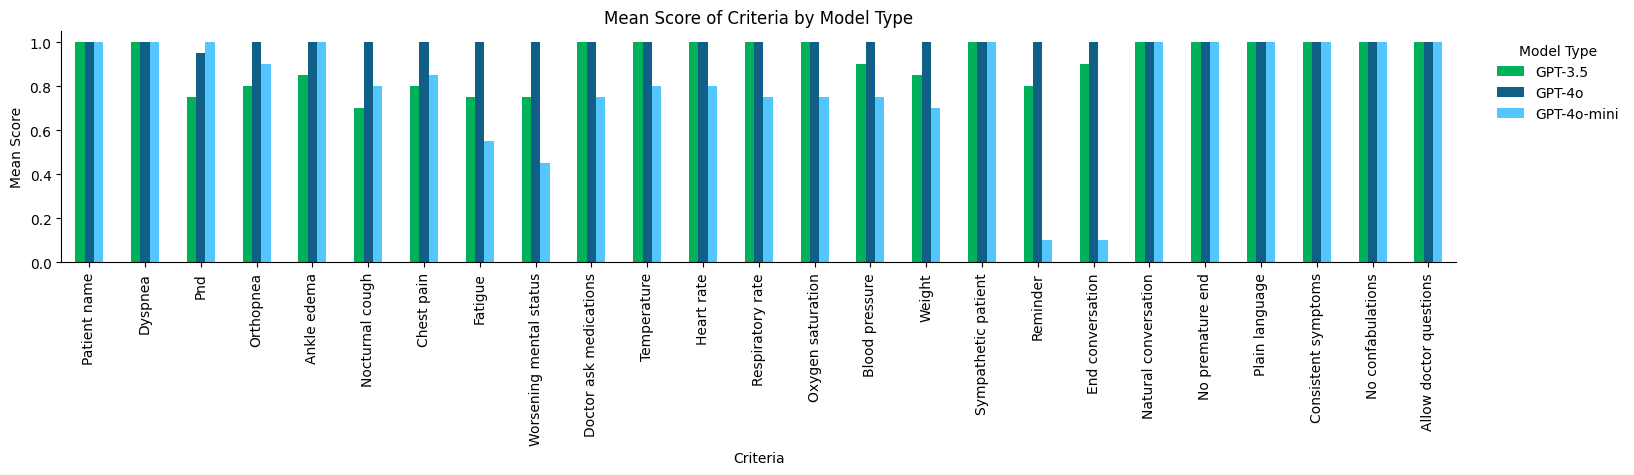

/var/folders/qp/hy557z1d5_5ckqwp_fxv8j440000gn/T/ipykernel_70876/2150629575.py:44: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_average_over_patients = df.groupby("patient_type")[list(judge_criteria.keys())].mean()
/var/folders/qp/hy557z1d5_5ckqwp_fxv8j440000gn/T/ipykernel_70876/2150629575.py:50: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_average_over_criteria_type = df_average_over_patients.groupby(["model_type", "criteria_type"])["mean_score"].mean().unstack().T


model_type,GPT-3.5,GPT-4o,GPT-4o-mini
criteria_type,,,
hcp_quality,0.940000,1.00000,0.640000
medications,1.000000,1.00000,0.750000
symptoms,0.800000,0.99375,0.818750
vitals,0.958333,1.00000,0.758333


([<matplotlib.axis.XTick at 0x16bde0c90>,
 [Text(0, 0, 'Symptoms'),
  Text(1, 0, 'Medications'),
  Text(2, 0, 'Vitals'),
  Text(3, 0, 'Hcp quality')])

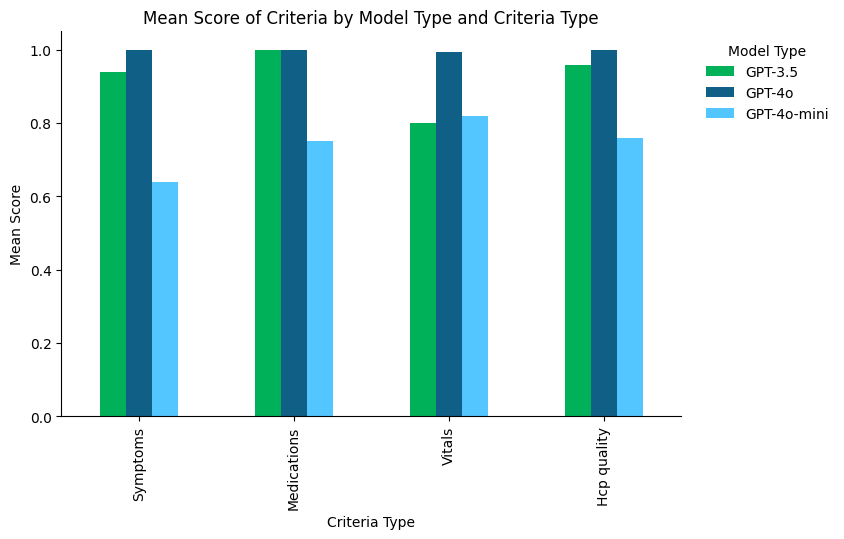

In [211]:
df = pd.read_csv("2.1_llm_judge_transcript_results.csv")  # load the saved file

df.groupby("patient_type")[list(judge_criteria.keys())].mean()

# plot bar plot
df["patient_type"] = pd.Categorical(
    df["patient_type"], ["gpt3.5_cooperative_basedoc", "4o_cooperative_basedoc", "cooperative_basedoc"]
)
df = df.sort_values("patient_type")

# rename patient types
df["patient_type"] = df["patient_type"].replace({
    "gpt3.5_cooperative_basedoc": "GPT-3.5",
    "4o_cooperative_basedoc": "GPT-4o",
    "cooperative_basedoc": "GPT-4o-mini",
})

# replace colors. use light green, dark blue, light blue
colors = ["#00b159", "#105f87", "#54c6ff"]

df.groupby("patient_type")[list(judge_criteria.keys())].mean().T.plot(kind="bar", figsize=(18, 3), color=colors)

plt.legend(title="Model Type", bbox_to_anchor=(1.02, 1), loc='upper left', frameon=False)

plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

plt.xticks(ticks=range(len(judge_criteria)), labels=[x.replace("_", " ").capitalize() for x in judge_criteria.keys()])

plt.ylabel("Mean Score")
plt.xlabel("Criteria")
plt.title("Mean Score of Criteria by Model Type")

plt.show()

# then another plot where criteria is aggregated by question/crieria type
criteria_type = {
    "symptoms" : ["dyspnea", "pnd", "orthopnea", "ankle_edema", "nocturnal_cough", "chest_pain", "fatigue", "worsening_mental_status"],
    "medications" : ["doctor_ask_medications"],
    "vitals" : ["temperature", "heart_rate", "respiratory_rate", "oxygen_saturation", "blood_pressure", "weight"],
    "hcp_quality" : ["sympathetic_patient", "reminder", "end_conversation", "natural_conversation", "no_premature_end"],
}  # we're skipping all others

df_average_over_patients = df.groupby("patient_type")[list(judge_criteria.keys())].mean()
df_average_over_patients["model_type"] = df_average_over_patients.index

df_average_over_patients = df_average_over_patients.melt(id_vars="model_type", var_name="criteria", value_name="mean_score")
df_average_over_patients["criteria_type"] = df_average_over_patients["criteria"].apply(lambda x: next((k for k, v in criteria_type.items() if x in v), None))
df_average_over_patients = df_average_over_patients.dropna(subset=["criteria_type"])
df_average_over_criteria_type = df_average_over_patients.groupby(["model_type", "criteria_type"])["mean_score"].mean().unstack().T
display(df_average_over_criteria_type)
# plot bar plot
df_average_over_criteria_type.plot(kind="bar", figsize=(8, 5), color=colors)

# styling
plt.legend(title="Model Type", bbox_to_anchor=(1.02, 1), loc='upper left', frameon=False)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.ylabel("Mean Score")
plt.xlabel("Criteria Type")
plt.title("Mean Score of Criteria by Model Type and Criteria Type")
# capitialize the xticks
plt.xticks(ticks=range(len(criteria_type)), labels=[x.replace("_", " ").capitalize() for x in criteria_type.keys()])

In [ ]:
from pprint import pprint

patient_id = "13727153"
pprint(transcripts[patient_id]["chat_transcript"])
pprint(summaries[patient_id]["summary"])

In [ ]:
# viewer: open the csv file as a pandas dataframe

import pandas as pd

# view options -- max number of columns and column width
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_colwidth', 300)

df = pd.read_csv(csv_file_path)

display(df)